In [1]:

import numpy as np
from typing import List, Tuple
import gymnasium as gym
import gym_simplegrid
import matplotlib.pyplot as plt
import random

GENERAL_SEED = 19
random.seed(GENERAL_SEED)

In [2]:


def initialize_random_q_table(env, goal_state=15):
    new_seed = random.randint(1, 100000)
    np.random.seed(new_seed)
    q_table = np.random.uniform(low=0, high=0.1, size=(env.observation_space.n, env.action_space.n))
    q_table[goal_state, :] = 0  # Ensure the goal state has Q-values of 0
    return q_table

def epsilon_greedy_policy(q_table, state, epsilon, env):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
        return action
    else:
        return np.argmax(q_table[state])  # Exploit: choose best action

def train_q_learning(
    env: gym.Env,
    q_table_list,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.999,
    episodes: int = 10000,
    num_runs: int = 3,
    options={
        'start_loc': 0,
        'goal_loc': 15}
):
    """Trains an agent using the Q-learning algorithm on a specified environment and performs multiple runs for statistical analysis."""

    avg_steps_list = np.zeros((num_runs,episodes))
    avg_success_rate_list = np.zeros((num_runs,episodes))
    avg_reward_list = np.zeros((num_runs,episodes))
    avg_epsilon_list = np.zeros((num_runs,episodes))
    avg_mean_max_list = np.zeros((num_runs,episodes))

    for run_idx in range(num_runs):
        print(f"QL: Run {run_idx + 1} / {num_runs}")

        q_table = np.copy(q_table_list[run_idx])

        env.reset(options=options)
        epsilon = initial_epsilon

        for episode in range(episodes):
            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset(options=options)[0]
            truncated, done = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection
                action = epsilon_greedy_policy(q_table, state, epsilon, env)

                next_state, reward, done, truncated, _ = env.step(action)

                # Q-Learning update rule
                q_table[state, action] = q_table[state, action] + alpha * (
                    reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
                )
                state = next_state
                
            avg_epsilon_list[run_idx][episode] = epsilon
            # Epsilon decay
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            # Evaluate current q-table
            avg_steps, success_rate, avg_reward, mean_max_q = evaluation_policy(env, q_table)

            # Append the evaluation metrics for this run
            avg_steps_list[run_idx][episode] = avg_steps
            avg_success_rate_list[run_idx][episode] = success_rate
            avg_reward_list[run_idx][episode] = avg_reward
            avg_mean_max_list[run_idx][episode] = mean_max_q

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        avg_mean_max_over_runs = np.mean(avg_mean_max_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs, avg_mean_max_over_runs


def train_double_q_learning(
    env: gym.Env,
    q_table_list, 
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    episodes: int = 10000,
    num_runs: int = 3,
    options={
        'start_loc': 0,
        'goal_loc': 15}
):
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment and performs multiple runs.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        num_runs (int): Number of runs for statistical analysis.

    Returns: Q-tables
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs,episodes))
    avg_mean_max_list = np.zeros((num_runs,episodes))

    for run_idx in range(num_runs):
        print(f"DQL: Run {run_idx + 1} / {num_runs}")

        q_table_a = np.copy(q_table_list[run_idx])
        # q_table_a = np.zeros((env.observation_space.n, env.action_space.n))
        q_table_b = np.copy(q_table_a)

        env.reset(options=options)

        epsilon = initial_epsilon
        
        for episode in range(episodes):
            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset(options=options)[0] if isinstance(env.reset(options=options), tuple) else env.reset(options=options)  # Fix if reset returns tuple
            done, truncated = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection using the average of Q-tables A and B
                action = epsilon_greedy_policy((q_table_b + q_table_a) / 2, state=state, epsilon=epsilon, env=env)

                next_state, reward, done, truncated, _ = env.step(action)

                if np.random.uniform(0, 1) < 0.5:
                    best_next_action = np.argmax(q_table_a[next_state, :])
                    td_target = reward + gamma * q_table_b[next_state, best_next_action]
                    q_table_a[state, action] += alpha * (td_target - q_table_a[state, action])
                else:
                    best_next_action = np.argmax(q_table_b[next_state, :])
                    td_target = reward + gamma * q_table_a[next_state, best_next_action]
                    q_table_b[state, action] += alpha * (td_target - q_table_b[state, action])
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon
            epsilon = max(min_epsilon, epsilon_decay * epsilon)
            if episode % 1 == 0:
                avg_steps, success_rate, avg_reward, mean_max_q = evaluation_policy(env, (q_table_b + q_table_a) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_mean_max_list[run_idx][episode] = mean_max_q


        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        avg_mean_max_over_runs = np.mean(avg_mean_max_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    print("Double Q-learning multiple runs completed.")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs, avg_mean_max_over_runs


def asynchronous_speedy_q_learning(
    env,
    q_table_list,
    mask_hole_indeces,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    total_time_steps: int = 100000,
    episodes = 100,
    num_runs: int = 3,
    options={
        'start_loc': 0,
        'goal_loc': 15}
):
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs,episodes))
    avg_mean_max_list = np.zeros((num_runs,episodes))

    for run_idx in range(num_runs):

        print(f"SQL: Run {run_idx + 1} / {num_runs}")
        Q_k = np.copy(q_table_list[run_idx])
        Q_k_minus_1 = np.copy(Q_k)

        env.reset(options=options)
    
        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        alpha = 1

        k = 0
        N = np.zeros((state_space, action_space), dtype=int)
        state = env.reset(options=options)[0]
        t = 0

        epsilon = initial_epsilon

        done, truncated = False, False

        episode = 0
        while t <= total_time_steps and episode < episodes:
            action = epsilon_greedy_policy(Q_k, state, epsilon, env)
            next_state, reward, done, truncated, _ = env.step(action)

            eta = 1 / (N[state][action] + 1)

            # Compute temporal differences
            best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
            best_next_action_k = np.argmax(Q_k[next_state])
            T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (
                reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
            T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (
                reward + gamma * Q_k[next_state, best_next_action_k])

            # Update Q_k+1
            Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k - 1) * T_kQ_k_minus_1)
            N[state][action] += 1

            # Update Q-table references
            Q_k_minus_1 = np.copy(Q_k)
            Q_k[state, action] = np.copy(Q_k_plus_1)
            
            state = next_state

            # Check if all state-action pairs have been visited
            if np.min(N[mask_hole_indeces]) > 0:
                # print("N got reset")
                k += 1
                alpha = 1 / (k + 1)
                N = np.zeros_like(N) 

            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward, mean_max_q = evaluation_policy(env, Q_k)
                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                avg_mean_max_list[run_idx][episode] = mean_max_q

                epsilon = max(min_epsilon, epsilon_decay * epsilon)
                episode += 1
                state = env.reset(options=options)[0]

                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        avg_mean_max_over_runs = np.mean(avg_mean_max_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
    
    print(f"episode ended in SQL: {episode}")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs, avg_mean_max_over_runs


def ultimate_sdql_training(
    env,
    q_table_list,
    mask_hole_indeces,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.05,
    epsilon_decay: float = 0.99995,
    total_time_steps: int = 100000,
    episodes = 100,
    num_runs: int = 3,
    options={
        'start_loc': 0,
        'goal_loc': 15}
) -> Tuple:
    """
    Trains an agent using the Ultimate Speedy Double Q-learning (SDQL) algorithm over multiple runs for statistical analysis.

    Args:
        env: The environment to train the agent on.
        epsilon: Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon: Minimum value that epsilon can decay to.
        epsilon_decay: Rate at which epsilon decays after each step.
        T: Total number of time steps.
        gamma: Discount factor for future rewards.
        eval_interval: Frequency of evaluation during training.
        eval_episodes: Number of episodes to run during evaluation.
        num_runs: Number of runs for statistical analysis.
        seeds: List of seeds for reproducibility.

    Returns:
        A tuple containing:
        - Average cumulative rewards across all runs.
        - Standard deviation of rewards.
        - Average episode lengths.
        - Standard deviation of episode lengths.
        - Average epsilon values.
        - Standard deviation of epsilon values.
        - Time steps.
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs,episodes))
    avg_mean_max_list = np.zeros((num_runs,episodes))

    for run_idx in range(num_runs):
        print(f"SDQL: Run {run_idx + 1} / {num_runs}")

        env.reset(options=options)

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        Q_A = np.copy(q_table_list[run_idx])
        Q_B = np.copy(Q_A)
        Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

        N_A = np.zeros((state_space, action_space))
        N_B = np.zeros((state_space, action_space))

        k_A = k_B = t = 0
        alpha_A = alpha_B = 1

        state = env.reset(options=options)[0]

        epsilon = initial_epsilon
        
        episode = 0
        while t <= total_time_steps and episode < episodes:
            action = epsilon_greedy_policy((Q_A + Q_B) / 2, state, epsilon, env)

            next_state, reward, done, truncated, _ = env.step(action)

            if np.random.uniform(0, 1) < 0.5:  # Update Q_A
                eta = 1 / (N_A[state, action] + 1)
                a_star = np.argmax(Q_A_minus_1[next_state, :])
                a_plus = np.argmax(Q_A[next_state, :])

                T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (
                    reward + gamma * Q_B_minus_1[next_state, a_star])
                T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (
                    reward + gamma * Q_B[next_state, a_plus])

                Q_A_minus_1[state, action] = Q_A[state, action]
                Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (
                    k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
                N_A[state, action] += 1
            else:  # Update Q_B
                eta = 1 / (N_B[state, action] + 1)
                a_star = np.argmax(Q_B_minus_1[next_state, :])
                a_plus = np.argmax(Q_B[next_state, :])
                T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                    reward + gamma * Q_A_minus_1[next_state, a_star])
                T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (
                    reward + gamma * Q_A[next_state, a_plus])

                Q_B_minus_1[state, action] = Q_B[state, action]
                Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                    k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
                N_B[state, action] += 1

            state = next_state

            # Update counters and learning rates if needed
            if np.min(N_A[mask_hole_indeces]) > 0:
                # print("N_A got reset")
                k_A += 1
                alpha_A = 1 / (k_A + 1)
                N_A.fill(0)  # Reset visit counts for A
            

            if np.min(N_B[mask_hole_indeces]) > 0:
                # print("N_B got reset")
                k_B += 1
                alpha_B = 1 / (k_B + 1)
                N_B.fill(0)  # Reset visit counts for B

            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward, mean_max_q = evaluation_policy(env, (Q_A + Q_B) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_mean_max_list[run_idx][episode] = mean_max_q

                avg_epsilon_list[run_idx][episode] = epsilon
                
                epsilon = max(min_epsilon, epsilon_decay * epsilon)

                episode += 1
                state = env.reset(options=options)[0]

                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        avg_mean_max_over_runs = np.mean(avg_mean_max_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    print(f"episode ended in SDQL: {episode}")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs, avg_mean_max_over_runs

def track_max_q_values(q_table, state_space):
    max_q_values = [np.max(q_table[s]) for s in range(state_space)]
    return np.mean(max_q_values)

def evaluation_policy(env, q_table,
    options={
        'start_loc': 0,
        'goal_loc': 15}):
    """
    Evaluates the agent's policy using the Q-table by running a number of episodes.
    Tracks the number of steps, success rate, and total rewards.
    
    Parameters:
        env: gym.Env - The environment.
        q_table: np.array - The Q-table for the agent.
    
    Returns:
        A tuple of (average steps, average success rate, average reward).
    """
    total_successes = 0

    state = env.reset(options=options)[0]  # Reset the environment at the start of each episode
    done, truncated = False, False

    episode_steps = 0
    episode_reward = 0

    goal_state = options['goal_loc']  # Define goal state from options

    while not (done or truncated):
        # Choose the best action from Q-table (greedy policy)
        action = np.argmax(q_table[state])

        next_state, reward, done, truncated, info = env.step(action)

        episode_reward += reward
        episode_steps += 1

        state = next_state

        if info.get('goal_reached', False) or state == goal_state:
            done=True
            total_successes+=1

    mean_max_q = track_max_q_values(q_table, env.observation_space.n)
    return episode_steps, total_successes, episode_reward, mean_max_q


In [3]:
def compare_algorithms(results, titles):
    # Create a figure with 4 rows and 1 column, slightly smaller figure size
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 16))  # Increased the size for more space

    # Hardcoded colors for plotting
    colors = ['b', 'g', 'r', 'purple']

    # Plot Average Steps with Std Deviation (Shadows)
    ax1 = axes[0]
    for i, (avg_steps, _, _, _, std_steps, _, _) in enumerate(results):
        ax1.plot(avg_steps, color=colors[i], label=f'{titles[i]}')
        ax1.fill_between(range(len(avg_steps)), 
                         np.array(avg_steps) - np.array(std_steps),
                         np.array(avg_steps) + np.array(std_steps),
                         color=colors[i], alpha=0.2)
    ax1.set_title("Average Steps per Episode", fontsize=14)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Average Steps Number", fontsize=12)
    ax1.legend() 

    # Plot Average Success Rate (No Std Deviation Needed)
    ax2 = axes[1]
    for i, (_, avg_success_rate, _, _, _, _, _) in enumerate(results):
        ax2.plot(avg_success_rate, color=colors[i], label=f'{titles[i]}')
    ax2.set_title("Cumulative Success Rate per Episode", fontsize=12)
    ax2.set_xlabel("Episode", fontsize=11)
    ax2.set_ylabel("Success Rate", fontsize=11)
    ax2.legend() 

    # Plot Average Reward with Std Deviation (Shadows)
    ax3 = axes[2]
    for i, (_, _, avg_rewards, _, _, std_rewards, _) in enumerate(results):
        ax3.plot(avg_rewards, color=colors[i], label=f'{titles[i]}')
        ax3.fill_between(range(len(avg_rewards)), 
                         np.array(avg_rewards) - np.array(std_rewards),
                         np.array(avg_rewards) + np.array(std_rewards),
                         color=colors[i], alpha=0.2)
    ax3.set_title("Cumulative Reward per Episode", fontsize=12)
    ax3.set_xlabel("Episode", fontsize=11)
    ax3.set_ylabel("Reward", fontsize=11)
    ax3.legend() 

    # Plot Epsilon Decay (Assuming You Have Epsilon Data to Plot)
    ax4 = axes[3]
    for i, (_, _, _, avg_epsilons, _, _, _) in enumerate(results):
        ax4.plot(avg_epsilons, color=colors[i], label=f'{titles[i]}')
    ax4.set_title("Epsilon Decay", fontsize=12)
    ax4.set_xlabel("Episode", fontsize=11)
    ax4.set_ylabel("Epsilon Value", fontsize=11)
    ax4.legend() 

    ax5 = axes[4]
    for i, (_, _, _, _, _, _, avg_max_q) in enumerate(results):
        ax5.plot(avg_max_q, color=colors[i], label=f'{titles[i]}')
    ax5.set_title("Average Max Q", fontsize=12)
    ax5.set_xlabel("Episode", fontsize=11)
    ax5.set_ylabel("Mean Max Q", fontsize=11)
    ax5.legend() 

    # Add a legend common for all plots, move it to the bottom
    # fig.legend(labels=titles, loc='lower center', ncol=len(titles), fontsize='medium', bbox_to_anchor=(0.5, -0.05))

    # Add more vertical space between subplots to avoid overlap
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between plots

    # Adjust the layout to fit all elements and avoid overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    plt.show()

In [4]:
obstacle_map = [
    "0000",
    "0101",
    "0001",
    "1000",
]
env = gym.make('SimpleGrid-4x4-v0')#, obstacle_map=obstacle_map)

q_list = []

num_runs=20
for run in range(num_runs):
    q_list.append(initialize_random_q_table(env))

q_list = [initialize_random_q_table(env) for _ in range(num_runs)]


options = {
    'start_loc': 0,
    'goal_loc': 15
}

mask_hole_indeces = [True if i not in [5, 7, 11, 12, 15] else False for i in range(16)]


QL: Run 1 / 20
QL: Run 2 / 20
QL: Run 3 / 20
QL: Run 4 / 20
QL: Run 5 / 20
QL: Run 6 / 20
QL: Run 7 / 20
QL: Run 8 / 20
QL: Run 9 / 20
QL: Run 10 / 20
QL: Run 11 / 20
QL: Run 12 / 20
QL: Run 13 / 20
QL: Run 14 / 20
QL: Run 15 / 20
QL: Run 16 / 20
QL: Run 17 / 20
QL: Run 18 / 20
QL: Run 19 / 20
QL: Run 20 / 20
DQL: Run 1 / 20
DQL: Run 2 / 20
DQL: Run 3 / 20
DQL: Run 4 / 20
DQL: Run 5 / 20
DQL: Run 6 / 20
DQL: Run 7 / 20
DQL: Run 8 / 20
DQL: Run 9 / 20
DQL: Run 10 / 20
DQL: Run 11 / 20
DQL: Run 12 / 20
DQL: Run 13 / 20
DQL: Run 14 / 20
DQL: Run 15 / 20
DQL: Run 16 / 20
DQL: Run 17 / 20
DQL: Run 18 / 20
DQL: Run 19 / 20
DQL: Run 20 / 20
Double Q-learning multiple runs completed.
SQL: Run 1 / 20
SQL: Run 2 / 20
SQL: Run 3 / 20
SQL: Run 4 / 20
SQL: Run 5 / 20
SQL: Run 6 / 20
SQL: Run 7 / 20
SQL: Run 8 / 20
SQL: Run 9 / 20
SQL: Run 10 / 20
SQL: Run 11 / 20
SQL: Run 12 / 20
SQL: Run 13 / 20
SQL: Run 14 / 20
SQL: Run 15 / 20
SQL: Run 16 / 20
SQL: Run 17 / 20
SQL: Run 18 / 20
SQL: Run 19 / 20
S

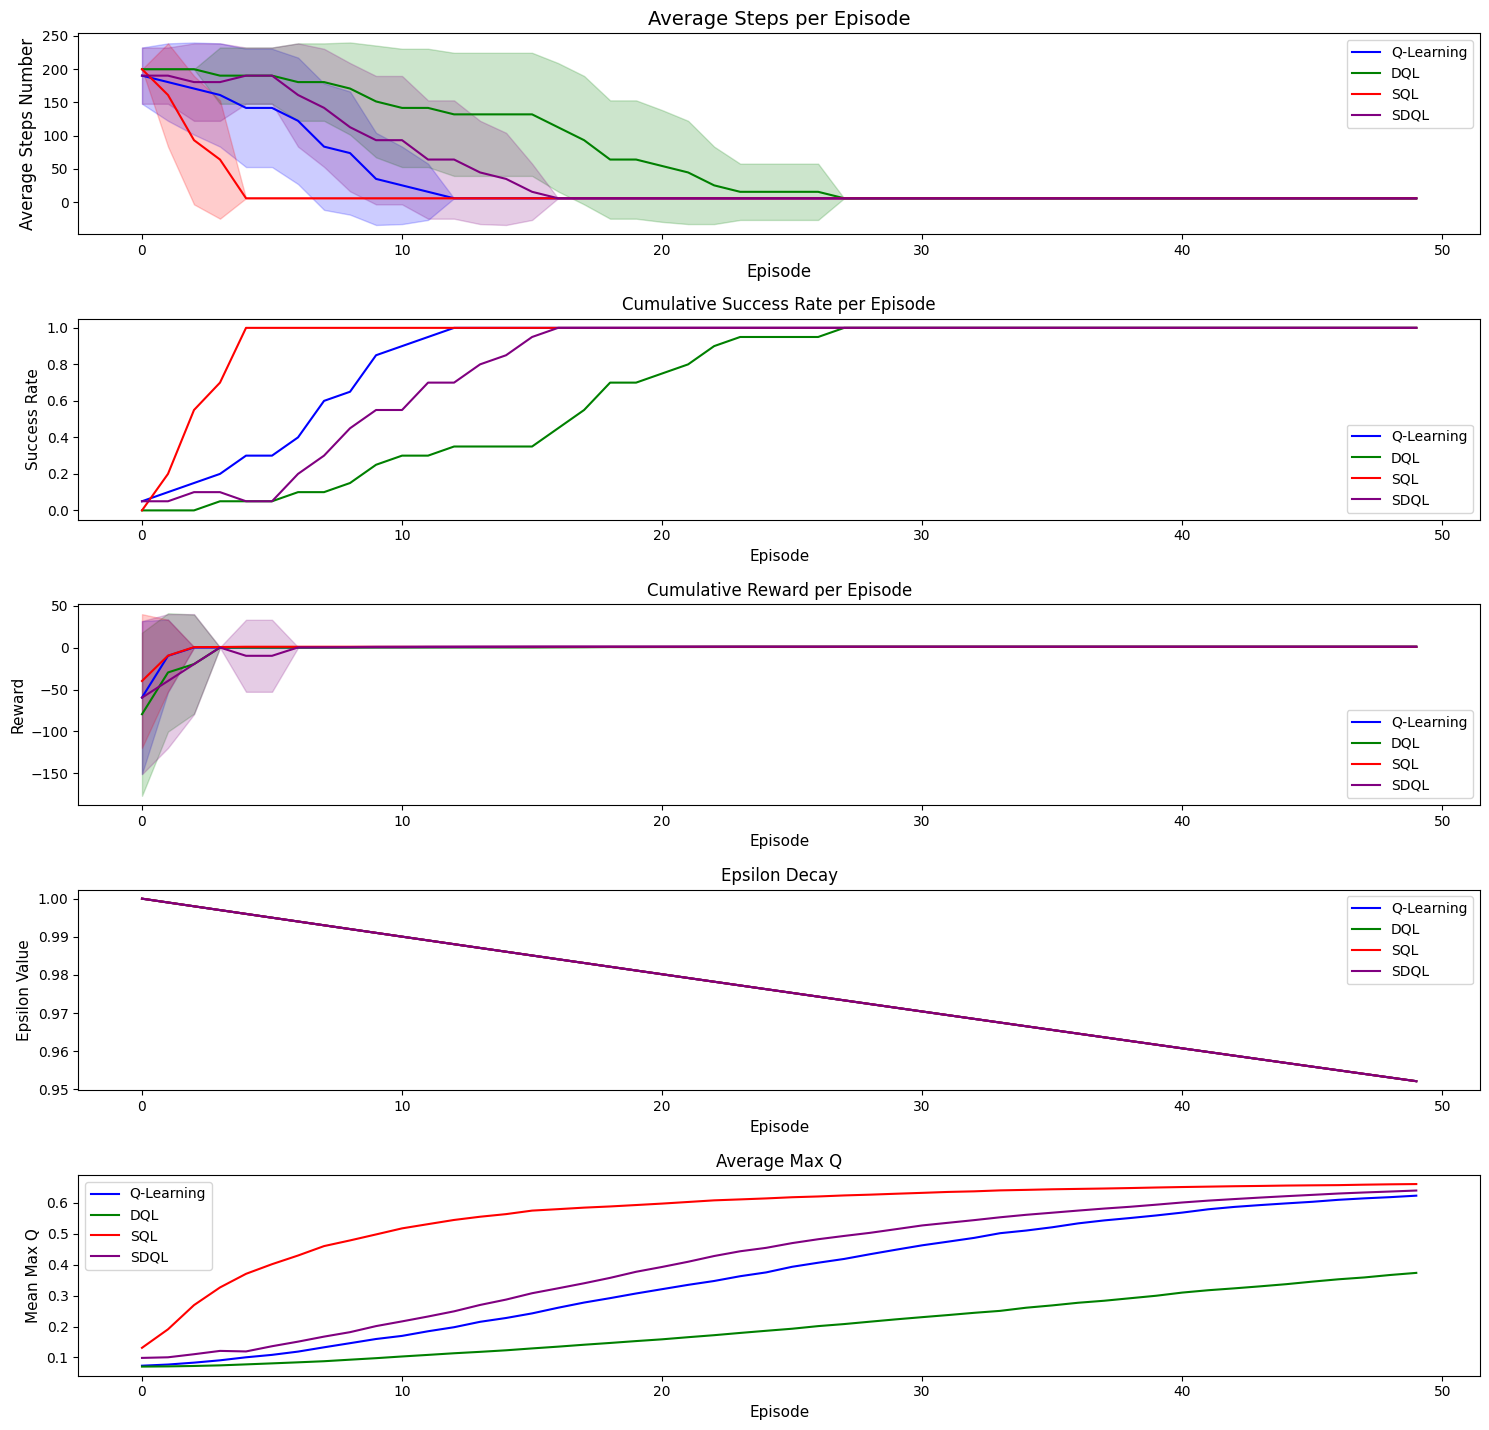

In [5]:
episodes = 50
q_learning_results = train_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, options=options, epsilon_decay=0.999)
env.reset(options=options)
double_q_learning_results = train_double_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.999, options=options)

env.reset(options=options)
asynchronous_speedy_q_learning_results = asynchronous_speedy_q_learning(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.999)
env.reset(options=options)
ultimate_sdql_results = ultimate_sdql_training(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.999)

# Store the results in a list
algorithms_results = [
    q_learning_results,
    double_q_learning_results,
    asynchronous_speedy_q_learning_results,
    ultimate_sdql_results
]

# Corresponding algorithm names
algorithms_names = [
    "Q-Learning",
    "DQL",
    "SQL",
    "SDQL"
]

# Plot comparison of all algorithms
compare_algorithms(algorithms_results, algorithms_names)

In [14]:
def compare_algorithms(results, titles):
    # Create a figure with 4 rows and 1 column, slightly smaller figure size
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 16))  # Increased the size for more space

    # Hardcoded colors for plotting
    colors = ['b', 'g', 'r', 'purple']

    # Plot Average Steps with Std Deviation (Shadows)
    ax1 = axes[0]
    for i, (avg_steps, _, _, _, std_steps, _, _) in enumerate(results):
        ax1.plot(avg_steps, color=colors[i], label=f'{titles[i]}')
        ax1.fill_between(range(len(avg_steps)), 
                         np.array(avg_steps) - np.array(std_steps),
                         np.array(avg_steps) + np.array(std_steps),
                         color=colors[i], alpha=0.2)
    ax1.set_title("Average Steps per Episode", fontsize=14)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Average Steps Number", fontsize=12)
    ax1.legend() 

    # Plot Average Success Rate (No Std Deviation Needed)
    ax2 = axes[1]
    for i, (_, avg_success_rate, _, _, _, _, _) in enumerate(results):
        ax2.plot(avg_success_rate, color=colors[i], label=f'{titles[i]}')
    ax2.set_title("Cumulative Success Rate per Episode", fontsize=12)
    ax2.set_xlabel("Episode", fontsize=11)
    ax2.set_ylabel("Success Rate", fontsize=11)
    ax2.legend() 

    # Plot Average Reward with Std Deviation (Shadows)
    ax3 = axes[2]
    for i, (_, _, avg_rewards, _, _, std_rewards, _) in enumerate(results):
        # Limit the plot to the first 30 episodes
        episodes_to_plot = 30
        ax3.plot(avg_rewards[:episodes_to_plot], color=colors[i], label=f'{titles[i]}')
        
        # Slice avg_rewards and std_rewards for the first 30 episodes
        ax3.fill_between(range(episodes_to_plot), 
                        np.array(avg_rewards[:episodes_to_plot]) - np.array(std_rewards[:episodes_to_plot]),
                        np.array(avg_rewards[:episodes_to_plot]) + np.array(std_rewards[:episodes_to_plot]),
                        color=colors[i], alpha=0.2)

    # Set y-axis limits to display only between -20 and 1.5
    ax3.set_ylim(-20, 5)

    ax3.set_title("Cumulative Reward per Episode", fontsize=12)
    ax3.set_xlabel("Episode", fontsize=11)
    ax3.set_ylabel("Reward", fontsize=11)
    ax3.legend()

    # Plot Epsilon Decay (Assuming You Have Epsilon Data to Plot)
    ax4 = axes[3]
    for i, (_, _, _, avg_epsilons, _, _, _) in enumerate(results):
        ax4.plot(avg_epsilons, color=colors[i], label=f'{titles[i]}')
    ax4.set_title("Epsilon Decay", fontsize=12)
    ax4.set_xlabel("Episode", fontsize=11)
    ax4.set_ylabel("Epsilon Value", fontsize=11)
    ax4.legend() 

    ax5 = axes[4]
    for i, (_, _, _, _, _, _, avg_max_q) in enumerate(results):
        ax5.plot(avg_max_q, color=colors[i], label=f'{titles[i]}')
    ax5.set_title("Average Max Q", fontsize=12)
    ax5.set_xlabel("Episode", fontsize=11)
    ax5.set_ylabel("Mean Max Q", fontsize=11)
    ax5.legend() 

    # Add a legend common for all plots, move it to the bottom
    # fig.legend(labels=titles, loc='lower center', ncol=len(titles), fontsize='medium', bbox_to_anchor=(0.5, -0.05))

    # Add more vertical space between subplots to avoid overlap
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between plots

    # Adjust the layout to fit all elements and avoid overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    plt.show()

QL: Run 1 / 20
QL: Run 2 / 20
QL: Run 3 / 20
QL: Run 4 / 20
QL: Run 5 / 20
QL: Run 6 / 20
QL: Run 7 / 20
QL: Run 8 / 20
QL: Run 9 / 20
QL: Run 10 / 20
QL: Run 11 / 20
QL: Run 12 / 20
QL: Run 13 / 20
QL: Run 14 / 20
QL: Run 15 / 20
QL: Run 16 / 20
QL: Run 17 / 20
QL: Run 18 / 20
QL: Run 19 / 20
QL: Run 20 / 20
DQL: Run 1 / 20
DQL: Run 2 / 20
DQL: Run 3 / 20
DQL: Run 4 / 20
DQL: Run 5 / 20
DQL: Run 6 / 20
DQL: Run 7 / 20
DQL: Run 8 / 20
DQL: Run 9 / 20
DQL: Run 10 / 20
DQL: Run 11 / 20
DQL: Run 12 / 20
DQL: Run 13 / 20
DQL: Run 14 / 20
DQL: Run 15 / 20
DQL: Run 16 / 20
DQL: Run 17 / 20
DQL: Run 18 / 20
DQL: Run 19 / 20
DQL: Run 20 / 20
Double Q-learning multiple runs completed.
SQL: Run 1 / 20
SQL: Run 2 / 20
SQL: Run 3 / 20
SQL: Run 4 / 20
SQL: Run 5 / 20
SQL: Run 6 / 20
SQL: Run 7 / 20
SQL: Run 8 / 20
SQL: Run 9 / 20
SQL: Run 10 / 20
SQL: Run 11 / 20
SQL: Run 12 / 20
SQL: Run 13 / 20
SQL: Run 14 / 20
SQL: Run 15 / 20
SQL: Run 16 / 20
SQL: Run 17 / 20
SQL: Run 18 / 20
SQL: Run 19 / 20
S

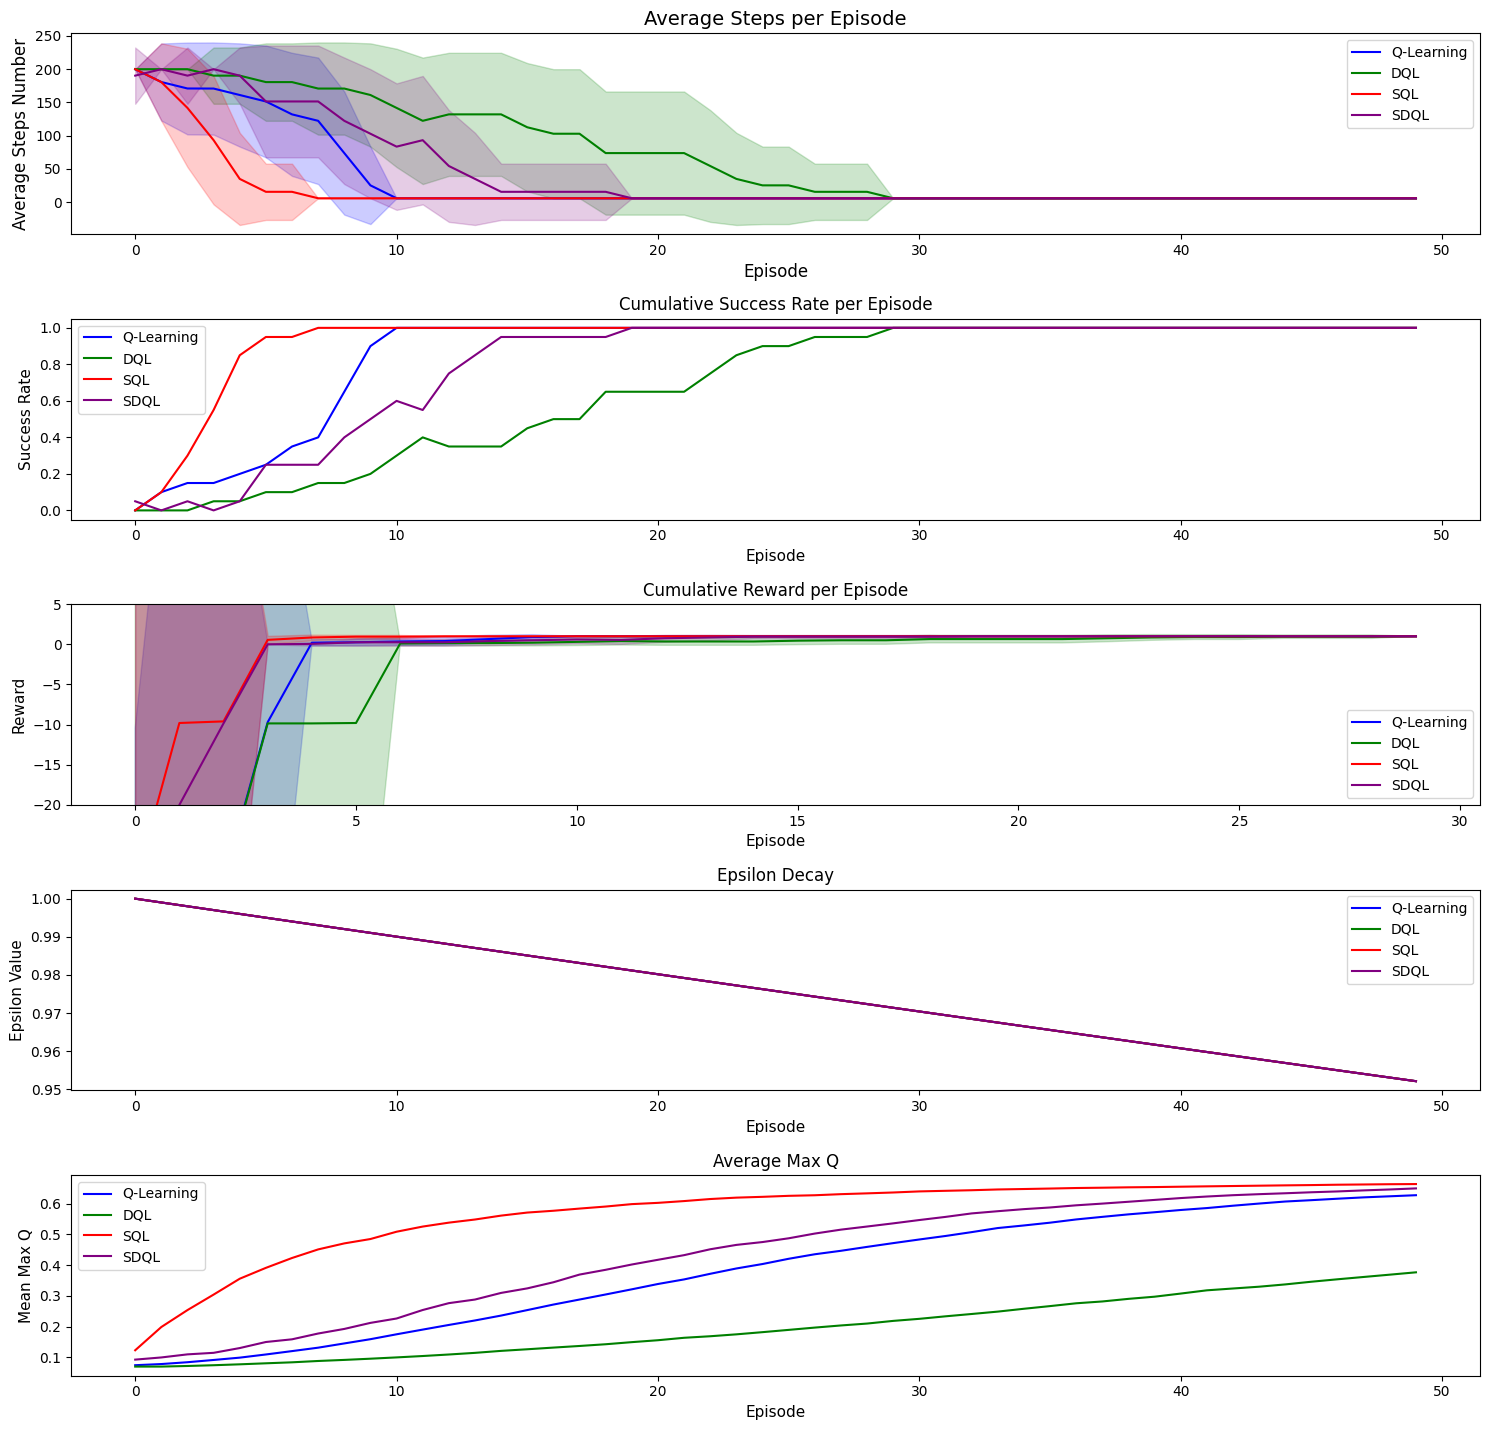

In [16]:
episodes = 50
q_learning_results = train_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, options=options, epsilon_decay=0.999)
env.reset(options=options)
double_q_learning_results = train_double_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.999, options=options)

env.reset(options=options)
asynchronous_speedy_q_learning_results = asynchronous_speedy_q_learning(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.999)
env.reset(options=options)
ultimate_sdql_results = ultimate_sdql_training(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.999)

# Store the results in a list
algorithms_results = [
    q_learning_results,
    double_q_learning_results,
    asynchronous_speedy_q_learning_results,
    ultimate_sdql_results
]

# Corresponding algorithm names
algorithms_names = [
    "Q-Learning",
    "DQL",
    "SQL",
    "SDQL"
]

# Plot comparison of all algorithms
compare_algorithms(algorithms_results, algorithms_names)

In [23]:

GENERAL_SEED = 1996
random.seed(GENERAL_SEED)

obstacle_map = [
    "00000001",
    "01010000",
    "00000100",
    "10001000",
]
env = gym.make('SimpleGrid-8x8-v0', obstacle_map=obstacle_map)

q_list = []

num_runs=20
for run in range(num_runs):
    q_list.append(initialize_random_q_table(env))

q_list = [initialize_random_q_table(env) for _ in range(num_runs)]

options = {
    'start_loc': 0,
    'goal_loc': 31
}

mask_hole_indeces = [True if i not in [7, 9, 11, 21, 24, 28, 31] else False for i in range(32)]

QL: Run 1 / 20
QL: Run 2 / 20
QL: Run 3 / 20
QL: Run 4 / 20
QL: Run 5 / 20
QL: Run 6 / 20
QL: Run 7 / 20
QL: Run 8 / 20
QL: Run 9 / 20
QL: Run 10 / 20
QL: Run 11 / 20
QL: Run 12 / 20
QL: Run 13 / 20
QL: Run 14 / 20
QL: Run 15 / 20
QL: Run 16 / 20
QL: Run 17 / 20
QL: Run 18 / 20
QL: Run 19 / 20
QL: Run 20 / 20
DQL: Run 1 / 20
DQL: Run 2 / 20
DQL: Run 3 / 20
DQL: Run 4 / 20
DQL: Run 5 / 20
DQL: Run 6 / 20
DQL: Run 7 / 20
DQL: Run 8 / 20
DQL: Run 9 / 20
DQL: Run 10 / 20
DQL: Run 11 / 20
DQL: Run 12 / 20
DQL: Run 13 / 20
DQL: Run 14 / 20
DQL: Run 15 / 20
DQL: Run 16 / 20
DQL: Run 17 / 20
DQL: Run 18 / 20
DQL: Run 19 / 20
DQL: Run 20 / 20
Double Q-learning multiple runs completed.
SQL: Run 1 / 20
SQL: Run 2 / 20
SQL: Run 3 / 20
SQL: Run 4 / 20
SQL: Run 5 / 20
SQL: Run 6 / 20
SQL: Run 7 / 20
SQL: Run 8 / 20
SQL: Run 9 / 20
SQL: Run 10 / 20
SQL: Run 11 / 20
SQL: Run 12 / 20
SQL: Run 13 / 20
SQL: Run 14 / 20
SQL: Run 15 / 20
SQL: Run 16 / 20
SQL: Run 17 / 20
SQL: Run 18 / 20
SQL: Run 19 / 20
S

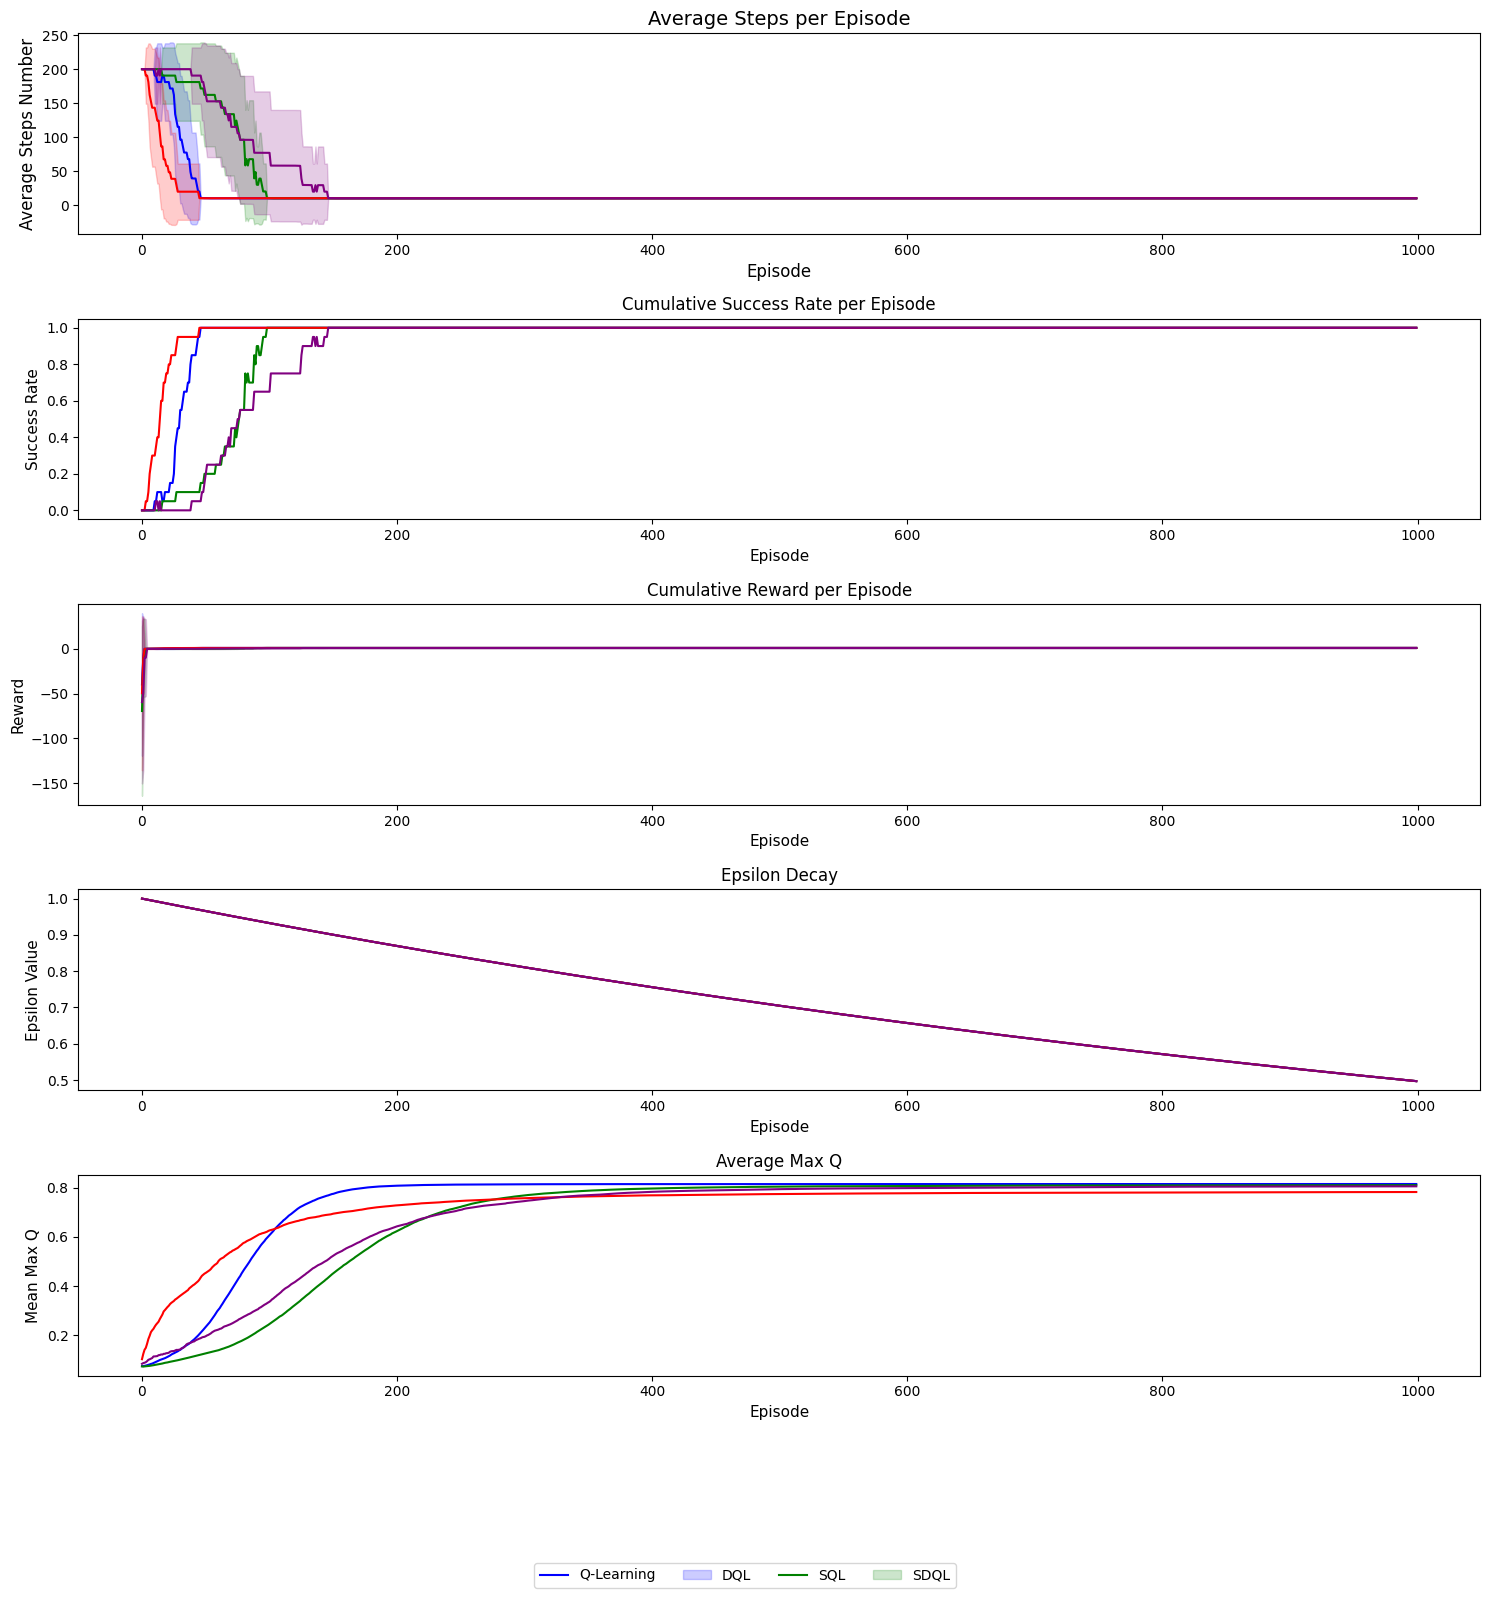

In [24]:
episodes = 1000
q_learning_results = train_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, options=options, epsilon_decay=0.9993)
env.reset(options=options)
double_q_learning_results = train_double_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.9993, options=options)

env.reset(options=options)
asynchronous_speedy_q_learning_results = asynchronous_speedy_q_learning(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.9993)
env.reset(options=options)
ultimate_sdql_results = ultimate_sdql_training(env, q_list, mask_hole_indeces, num_runs=num_runs, episodes=episodes, options=options, epsilon_decay=0.9993)

# Store the results in a list
algorithms_results = [
    q_learning_results,
    double_q_learning_results,
    asynchronous_speedy_q_learning_results,
    ultimate_sdql_results
]

# Corresponding algorithm names
algorithms_names = [
    "Q-Learning",
    "DQL",
    "SQL",
    "SDQL"
]

# Plot comparison of all algorithms
compare_algorithms(algorithms_results, algorithms_names)